# Problema seleccionado: Reconocimiento de dígitos en imágenes
Se entrenará un modelo para que sea capas de reconocer el número exterior de una casa a partir de una fotografía.

Se usará el dataset SVHN (Street View Of House Numbers), el cuál contiene 73,257 digitos de entrenamiento, 26,032 digitos para pruebas y  un conjunto extra de 531,131 digitos más sencillos de analizar, los cuáles pueden usarse para extender el entrenamiento del modelo, pero no se usarán en este ejercicio.

Se utilizará la variante del dataset que tiene una versión 32 x 32 de todas las imágenes.

In [3]:
# Montar la unidad de google drive donde se encuentran las imágenes

from google.colab import drive
drive.mount('/content/drive')

%cd "/content/drive/MyDrive/SVHN"

Mounted at /content/drive
/content/drive/MyDrive/SVHN


In [4]:
#imports

import numpy as np
import keras
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator

%matplotlib inline

In [5]:
# Establecer un estado aleatorio para numpy

np.random.seed(20)

In [6]:
# Cargar los datos

train_raw = loadmat('train_32x32.mat')
test_raw = loadmat('test_32x32.mat')

In [7]:
# Cargar las imágenes y sus etiquetas

train_images = np.array(train_raw['X'])
test_images = np.array(test_raw['X'])

train_labels = train_raw['y']
test_labels = test_raw['y']

In [ ]:
# Revisar las dimensiones de los datos

print(train_images.shape)
print(test_images.shape)

(32, 32, 3, 73257)
(32, 32, 3, 26032)


In [8]:
# Acomodar los ejes de las imágenes

train_images = np.moveaxis(train_images, -1, 0)
test_images = np.moveaxis(test_images, -1, 0)

print(train_images.shape)
print(test_images.shape)

(73257, 32, 32, 3)
(26032, 32, 32, 3)


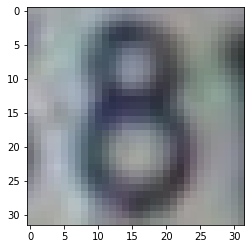

Label:  [8]


In [ ]:
# Graficar una imágen aleatoria con su etiqueta

plt.imshow(train_images[7610])
plt.show()

print('Label: ', train_labels[7610])

In [9]:
# Convertir las imágenes a 'float64'

train_images = train_images.astype('float64')
test_images = test_images.astype('float64')

# Convertir las etiquetas a 'int64'

train_labels = train_labels.astype('int64')
test_labels = test_labels.astype('int64')

In [10]:
# Escalar los datos
scaled_train_images = train_images/255.0
scaled_test_images = test_images/255.0

In [33]:
scaled_test_images[0]

array([[[0.14901961, 0.40392157, 0.23529412],
        [0.15294118, 0.40784314, 0.23921569],
        [0.15294118, 0.40784314, 0.24313725],
        ...,
        [0.16078431, 0.4       , 0.23921569],
        [0.16470588, 0.40392157, 0.24313725],
        [0.15294118, 0.38039216, 0.22352941]],

       [[0.15294118, 0.40784314, 0.23921569],
        [0.15294118, 0.40784314, 0.23921569],
        [0.15294118, 0.40784314, 0.24313725],
        ...,
        [0.16078431, 0.4       , 0.23921569],
        [0.16862745, 0.39607843, 0.24705882],
        [0.15294118, 0.38039216, 0.22352941]],

       [[0.14901961, 0.41176471, 0.24313725],
        [0.14509804, 0.40784314, 0.23921569],
        [0.15294118, 0.41568627, 0.24705882],
        ...,
        [0.16862745, 0.39607843, 0.24705882],
        [0.16862745, 0.39215686, 0.25098039],
        [0.15294118, 0.38039216, 0.23137255]],

       ...,

       [[0.20392157, 0.46666667, 0.30588235],
        [0.20784314, 0.47058824, 0.30980392],
        [0.2       , 0

In [11]:
# One-hot encoding de las etiquetas de entrenamiento y pruebas

lb = LabelBinarizer()
train_labels = lb.fit_transform(train_labels)
test_labels = lb.fit_transform(test_labels)

In [12]:
# Crear un set de validación a partir de los datos de entrenamiento

X_train, X_val, y_train, y_val = train_test_split(scaled_train_images, train_labels,
                                                  test_size=0.15, random_state=22)

In [13]:
# Data augmentation

datagen = ImageDataGenerator(rotation_range=8,
                             zoom_range=[0.95, 1.05],
                             height_shift_range=0.10,
                             shear_range=0.15)

In [ ]:
# Crear modelo

keras.backend.clear_session()

model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), padding='same', 
                           activation='relu',
                           input_shape=(32, 32, 3)),
    keras.layers.Conv2D(32, (3, 3), padding='same', 
                        activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), padding='same', 
                           activation='relu'),
    keras.layers.Conv2D(64, (3, 3), padding='same',
                        activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(128, (3, 3), padding='same', 
                           activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(128, (3, 3), padding='same',
                        activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3),
    
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.4),    
    keras.layers.Dense(10,  activation='softmax')
])

early_stopping = keras.callbacks.EarlyStopping(patience=8)
optimizer = keras.optimizers.Adam(lr=1e-3, amsgrad=True)
model_checkpoint = keras.callbacks.ModelCheckpoint(
                   '/kaggle/working/best_cnn.h5', 
                   save_best_only=True)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                    

In [ ]:
# Entrenar al modelo para hacer predicciones

history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=128),
                              epochs=10, validation_data=(X_val, y_val),
                              callbacks=[early_stopping, model_checkpoint])

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


487/487 [==============================] - 36s 74ms/step - loss: 1.0857 - accuracy: 0.6382 - val_loss: 1.4641 - val_accuracy: 0.8501
Epoch 2/10
487/487 [==============================] - 36s 74ms/step - loss: 0.5100 - accuracy: 0.8483 - val_loss: 0.3241 - val_accuracy: 0.9038
Epoch 3/10
487/487 [==============================] - 35s 72ms/step - loss: 0.4193 - accuracy: 0.8766 - val_loss: 0.2930 - val_accuracy: 0.9139
Epoch 4/10
487/487 [==============================] - 35s 71ms/step - loss: 0.3693 - accuracy: 0.8938 - val_loss: 0.2850 - val_accuracy: 0.9193
Epoch 5/10
487/487 [==============================] - 35s 72ms/step - loss: 0.3419 - accuracy: 0.9005 - val_loss: 0.2544 - val_accuracy: 0.9279
Epoch 6/10
487/487 [==============================] - 35s 71ms/step - loss: 0.3251 - accuracy: 0.9076 - val_loss: 0.2444 - val_accuracy: 0.9339
Epoch 7/10
487/487 [==============================] - 34s 69ms/step - loss: 0.3006 - accuracy: 0.9143 - val_loss: 0.2298 - val_accuracy: 0.9382
Epo

In [ ]:
# Evaluar precisiones de entrenamiento, validación y pérdidas

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

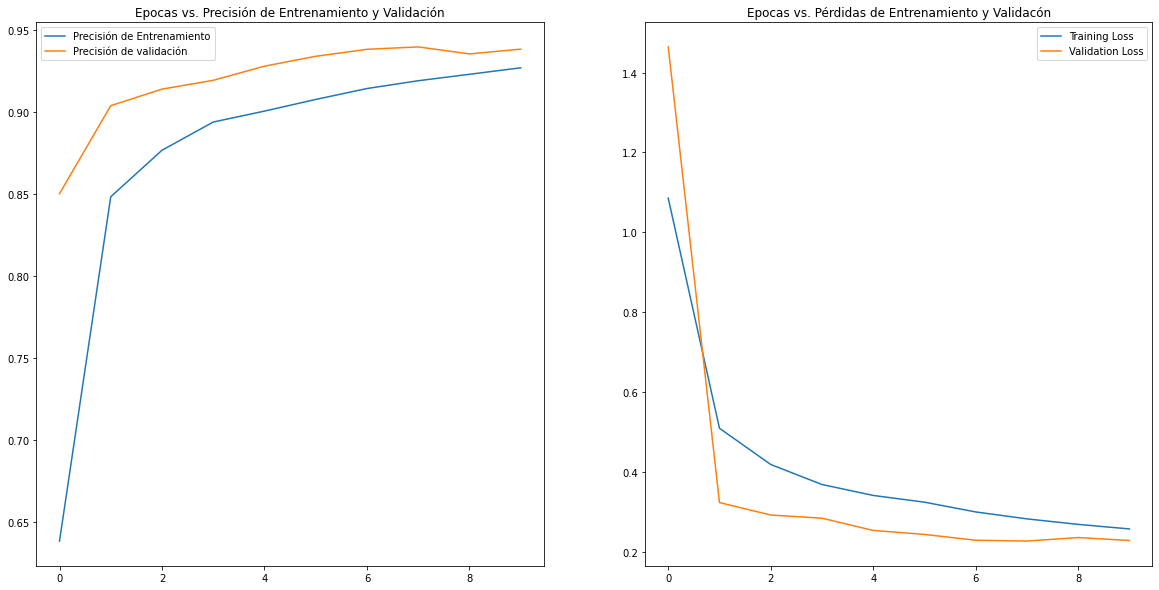

In [ ]:
# Visualizar epocas vs. precisión de entrenamiento, validación y pérdidas

plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Precisión de Entrenamiento')
plt.plot(val_acc, label='Precisión de validación')
plt.legend()
plt.title('Epocas vs. Precisión de Entrenamiento y Validación')
    
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title('Epocas vs. Pérdidas de Entrenamiento y Validacón')

plt.show()

In [ ]:
# Evaluar con el dataset de pruebas
test_loss, test_acc = model.evaluate(x=scaled_test_images, y=test_labels, verbose=0)

print('Test accuracy is: {:0.4f} \nTest loss is: {:0.4f}'.
      format(test_acc, test_loss))

Test accuracy is: 0.9397 
Test loss is: 0.2326


# Cambios al modelo
Cambios en la arquitectura:
- Antes se tenían 3 pares de redes convolucionales con capas de Max pooling entre ellas, ahora se implementaran 3 "bloques" con tres capas convolucionales, separadas por una capa de Max pooling y otra de dropout.
- Igualmente entre las capas convolucionales se agregará batch normalization.

Con estos nuevos cambios se busca conseguir un modelo más profundo, evitando el overfitting  y los problemas de gradientes con ayuda de la regularización.

In [25]:
# Nueva arquitectura
keras.backend.clear_session()

model = keras.Sequential([
    # Primer bloque
    keras.layers.Conv2D(32, (3, 3), padding='same',       # Capa convolucional número 1
                           activation='relu',
                           input_shape=(32, 32, 3)),
    keras.layers.BatchNormalization(),                    # Batch normalization
    keras.layers.Conv2D(32, (3, 3), padding='same',       # Capa convolucional número 2
                            activation='relu',
                            input_shape=(32, 32, 3)),
    keras.layers.BatchNormalization(),                    # Batch normalization
    keras.layers.Conv2D(32, (3, 3), padding='same',       # Capa convolucional número 3
                        activation='relu',
                        input_shape=(32, 32, 3)),
    keras.layers.MaxPooling2D((2, 2)),                    # Max pooling
    keras.layers.Dropout(0.3),                            # Drop out
    # Segundo bloque
    keras.layers.Conv2D(64, (3, 3), padding='same',       # Capa convolucional número 4
                           activation='relu'),
    keras.layers.BatchNormalization(),                    # Batch normalization
    keras.layers.Conv2D(64, (3, 3), padding='same',       # Capa convolucional número 5
                        activation='relu'),
    keras.layers.BatchNormalization(),                    # Batch normalization
    keras.layers.Conv2D(64, (3, 3), padding='same',       # Capa convolucional número 6
                        activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),                    # Max pooling
    keras.layers.Dropout(0.3),                            # Drop out
    # Tercer bloque
    keras.layers.Conv2D(128, (3, 3), padding='same',      # Capa convolucional número 7
                           activation='relu'),
    keras.layers.BatchNormalization(),                    # Batch normalization
    keras.layers.Conv2D(128, (3, 3), padding='same',      # Capa convolucional número 8
                        activation='relu'),
    keras.layers.BatchNormalization(),                    # Batch normalization
    keras.layers.Conv2D(128, (3, 3), padding='same',      # Capa convolucional número 9
                        activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),                    # Max pooling
    keras.layers.Dropout(0.3),                            # Drop out
    
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.4),    
    keras.layers.Dense(10,  activation='softmax')
])

early_stopping = keras.callbacks.EarlyStopping(patience=8)
optimizer = keras.optimizers.Adam(lr=1e-3, amsgrad=True)
model_checkpoint = keras.callbacks.ModelCheckpoint(
                   '/kaggle/working/best_cnn.h5', 
                   save_best_only=True)
model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0

In [27]:
# Entrenar al modelo para hacer predicciones

history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=128),
                              epochs=10, validation_data=(X_val, y_val),
                              callbacks=[early_stopping, model_checkpoint])

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


487/487 [==============================] - 42s 83ms/step - loss: 1.9797 - accuracy: 0.2910 - val_loss: 1.1860 - val_accuracy: 0.6060
Epoch 2/10
487/487 [==============================] - 39s 81ms/step - loss: 1.2357 - accuracy: 0.5623 - val_loss: 0.5103 - val_accuracy: 0.8615
Epoch 3/10
487/487 [==============================] - 37s 75ms/step - loss: 0.7095 - accuracy: 0.7772 - val_loss: 0.3803 - val_accuracy: 0.9000
Epoch 4/10
487/487 [==============================] - 38s 79ms/step - loss: 0.4490 - accuracy: 0.8750 - val_loss: 0.3007 - val_accuracy: 0.9155
Epoch 5/10
487/487 [==============================] - 38s 78ms/step - loss: 0.3722 - accuracy: 0.8975 - val_loss: 0.2714 - val_accuracy: 0.9243
Epoch 6/10
487/487 [==============================] - 41s 85ms/step - loss: 0.3293 - accuracy: 0.9085 - val_loss: 0.2277 - val_accuracy: 0.9396
Epoch 7/10
487/487 [==============================] - 38s 79ms/step - loss: 0.3029 - accuracy: 0.9163 - val_loss: 0.2311 - val_accuracy: 0.9385
Epo

In [28]:
# Evaluar precisiones de entrenamiento, validación y pérdidas

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

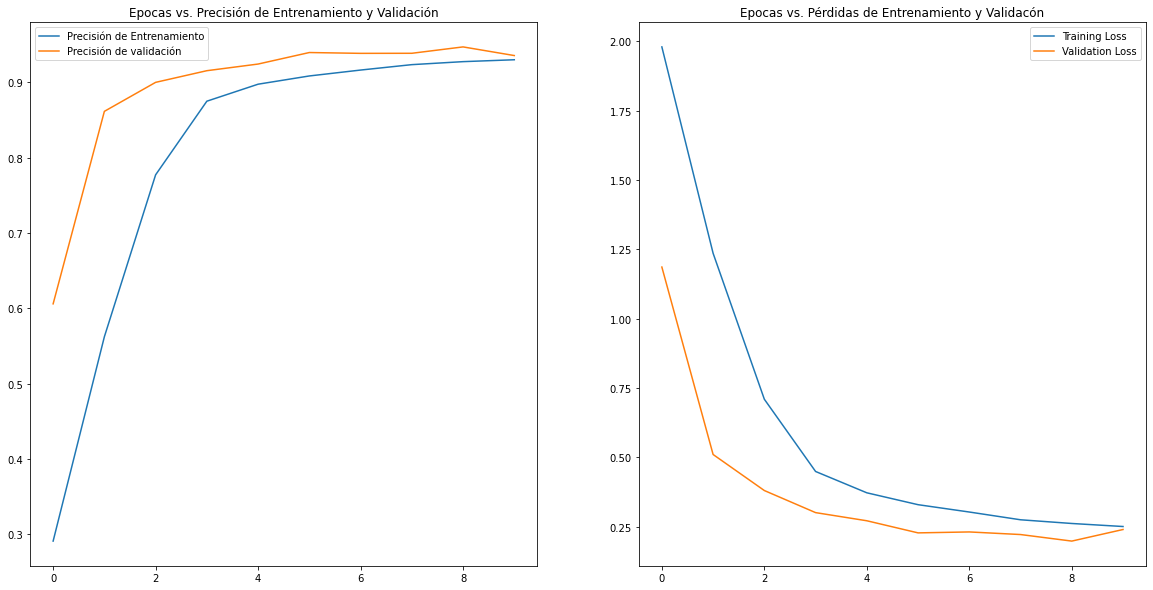

In [29]:
# Visualizar epocas vs. precisión de entrenamiento, validación y pérdidas

plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Precisión de Entrenamiento')
plt.plot(val_acc, label='Precisión de validación')
plt.legend()
plt.title('Epocas vs. Precisión de Entrenamiento y Validación')
    
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title('Epocas vs. Pérdidas de Entrenamiento y Validacón')

plt.show()

In [30]:
# Evaluar con el dataset de pruebas
test_loss, test_acc = model.evaluate(x=scaled_test_images, y=test_labels, verbose=0)

print('Test accuracy is: {:0.4f} \nTest loss is: {:0.4f}'.
      format(test_acc, test_loss))

Test accuracy is: 0.9420 
Test loss is: 0.2226


# Observaciones sobre las mejoras
El modelo tuvo una mejora mínima. Probablemente el aumentar el número de capas convolucionales no tuvo el efecto que se esperaba, sin embargo el introducir más capas de batch normalizacion y drop out fue un cambio efectivo que permitió tener más capas convolucionales en el modelo sin caer en overfitting.  

Probablemente hacer fine tunning mejoraría este modelo, ya que se se quisieran hacer cambios en la arquitectura, sería mejor implementar un nuevo modelo o hacer transfer learning.


1/1 [==============================] - 0s 17ms/step
Prediccion:  5


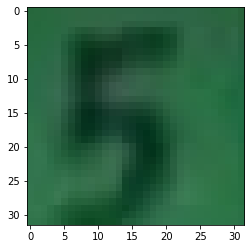

[0 0 0 0 1 0 0 0 0 0]
1/1 [==============================] - 0s 16ms/step
Prediccion:  4


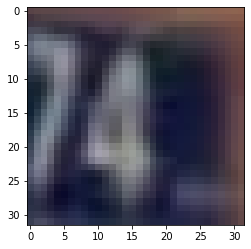

[0 0 0 1 0 0 0 0 0 0]
1/1 [==============================] - 0s 18ms/step
Prediccion:  3


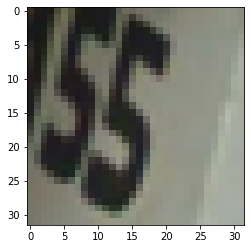

[0 0 0 0 1 0 0 0 0 0]


In [87]:
# Hacer algunas predicciones

def predict(img_num):
  ypred = model.predict(np.expand_dims(test_images[img_num], 0))[0]
  max = ypred[0]
  n = 1
  for i in range(len(ypred)):
    if ypred[i] > max:
      max = ypred[i]
      n = i + 1 
  return n

img_num = 0
ypred = predict(img_num)
print("Prediccion: ",ypred)
plt.imshow(scaled_test_images[img_num])
plt.show()
print(test_labels[img_num])

img_num = 100
ypred = predict(img_num)
print("Prediccion: ",ypred)
plt.imshow(scaled_test_images[img_num])
plt.show()
print(test_labels[img_num])

img_num = 1000
ypred = predict(img_num)
print("Prediccion: ",ypred)
plt.imshow(scaled_test_images[img_num])
plt.show()
print(test_labels[img_num])